<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import my_stats
import diagnostic_tools
import paths

import toe_calc as toe_calc
import toe_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import toe_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/136846996.gadi-pbs/matplotlib-yvvqvhhz because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
xr.set_options(display_expand_data=False)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [4]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [5]:
# client.close()

In [32]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=30, threads_per_worker=1, memory_limit=None) 
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:43931
 -   dashboard at:        /proxy/36655/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:37783'
 -         Start Nanny at: 'tcp://127.0.0.1:44487'
 -         Start Nanny at: 'tcp://127.0.0.1:40627'
 -         Start Nanny at: 'tcp://127.0.0.1:35519'
 -         Start Nanny at: 'tcp://127.0.0.1:45925'
 -         Start Nanny at: 'tcp://127.0.0.1:44333'
 -         Start Nanny at: 'tcp://127.0.0.1:34787'
 -         Start Nanny at: 'tcp://127.0.0.1:46089'
 -         Start Nanny at: 'tcp://127.0.0.1:37959'
 -         Start Nanny at: 'tcp://127.0.0.1:39727'
 -         Start Nanny at: 'tcp://127.0.0.1:42549'
 -         Start Nanny at: 'tcp://127.0.0.1:43189'
 -         Start Nanny at: 'tcp://127.0.0.1:44717'
 -         Start Nanny at: 'tcp://127.0.0.1:44369'
 -         Start Nanny at: 'tcp://127.0.0.1:40947'
 -         Start Nanny at: 'tcp://127.0.0.1:36415'
 -         Start Nanny at: 'tcp://127.0.0

<Client: 'tcp://127.0.0.1:43931' processes=30 threads=30>

 - Event loop was unresponsive in Nanny for 6.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 6.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 6.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 6.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 7.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 7.30s.  This is often caused by long

In [33]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [34]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'best_tas_(1880_1910)',
       'best_tas_(1890_1920)', 'best_tas_(1900_1930)',
       'best_tas_(1910_1940)', 'best_tas_(1920_1950)',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_32p0x32p0', 'best_tas_(1920_1950)_4p0x4p0',
       'best_tas_(1920_1950)_8p0x8p0', 'best_tas_(1930_1960)',
       'best_tas_(1940_1970)', 'best_tas_multi_base_period.zarr',
       'cesm1_lens_rcp85_tas_(1920_1950)',
       'cesm1_lens_rcp85_tas_multi_base_period.zarr', 'era5', 'old',
       'to_delete'], dtype='<U43')

In [35]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.BasePeriod(1880, 1909) # Base period should finish 1 year before
#toe_const.YearRange.ERA5_START
base_period, base_period.start, base_period.end

(BasePeriod(start=1880, end=1909), 1880, 1909)

In [36]:
base_period.length, base_period.value

(29, (1880, 1909))

In [207]:
variable = 'tas'
# model  =  'best'
# dataset_name = model
# dataset_name = f'{model}_{resolution}'


# experiment = 'rcp85'
# model = 'cesm1_lens'
model = 'access'
experiment = 'ssp585'

dataset_name = f'{model}_{experiment}'

#'gpcc', 'pr'#'era5',  'tx99count' # 'best', 'tas''tx99p9count'

In [38]:
# f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'

In [39]:
t_start = time()

In [40]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'best_tas_(1880_1910)',
       'best_tas_(1890_1920)', 'best_tas_(1900_1930)',
       'best_tas_(1910_1940)', 'best_tas_(1920_1950)',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_32p0x32p0', 'best_tas_(1920_1950)_4p0x4p0',
       'best_tas_(1920_1950)_8p0x8p0', 'best_tas_(1930_1960)',
       'best_tas_(1940_1970)', 'best_tas_multi_base_period.zarr',
       'cesm1_lens_rcp85_tas_(1920_1950)',
       'cesm1_lens_rcp85_tas_multi_base_period.zarr', 'era5', 'old',
       'to_delete'], dtype='<U43')

In [210]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})')
                            
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)'

In [211]:
os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# # I actually do want error if already exists
# # os.rmdir(VAR_SAVE_DIR)
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)

In [43]:
# chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}

# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}
ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': 72//12, 'lon':144//12}

# CHUNKS_FOR_ERA5 = {
#     'time': -1,
#     'lat': 721//7,
#     'lon':1440//24
# }

# chunks_for_gpcc = {
#     'time':-1,
#     'lat': 360//20,
#     'lon': 720//10
# }

In [44]:
chunks = ACCESS_CHUNKS#chunks_best_small# LE_CESM_CHUNKS

In [45]:
# If no ensemble
# plot_kwargs = {} 
# ensemble_kwargs = {}

# If ensemble
plot_kwargs = {'hue':'member', 'add_legend':False} 
ensemble_kwargs = {'member': 0}

<h2 style='color:cyan'> Data Functions </h2>

In [46]:
# data_ds = open_data.open_best(chunks_best_small).persist()

# data_ds = open_data.open_gpcc(resample='YE')
# # # Precip variables must have extra selections
# # # data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

In [47]:
# print(data_ds)

In [48]:
# from glob import glob
# var = 'tmax'
# path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}/*/*.nc'
# files_to_open = glob(path, recursive=True)
# print(len(files_to_open))
# td = xr.open_dataset(files_to_open[-30])

In [49]:
# resample = 'QS-JUN'#'QS-DEC' # 'YE'
# chunks = open_data.CHUNKS['access']['small']

# data_ds = open_data.open_access(
#     variable='pr',
#     ensemble='r10i1p1f1',
#     scenario='ssp585',
#     resample=resample
# ).chunk(chunks).isel(time=slice(1, None))

In [50]:
# import paths
# np.array(os.listdir(paths.ERA5_PATH))

In [51]:
# # Potential era5 variables - cape, skt (skin temperature), smlt (snow melt)
# # data_ds = open_data.open_era5('tmax', resample_method='max', save=True).isel(time=slice(None, -1))
# chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
# data_ds = open_data.open_era5(
#     't2m',
#     return_raw = False,
#     save = True,
#     resample_method = "sum",
#     logginglevel='INFO',
#     chunks = chunks,
# )
# data_ds = data_ds.isel(time=slice(None, -1))
# # data_das = open_data.open_era5_reanalysis('tmax') # Only use this if saving. Otherwise use open_era5

In [52]:
# data_ds

#### Regridding (optional)

Only done for BEST

In [53]:
# import xesmf

In [54]:
#  ds_out = xr.Dataset(
#     {
#         "lat": (["lat"], data_ds.lat.values[::32]),  # Every other latitude
#         "lon": (["lon"], data_ds.lon.values[::32])  # Every other longitude
#     }
# )
# ds_out

In [55]:
# regridder = xesmf.Regridder(data_ds, ds_out, method="bilinear")  # Use bilinear interpolation

In [56]:
# data_ds_regridded = regridder(data_ds).persist()
# wait(data_ds_regridded);

In [57]:
# fig = plt.figure(figsize=(18, 6))

# ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
# data_ds.isel(time=30).plot(ax=ax1, levels=np.arange(-4, 4.25, .25))
# data_ds_regridded.isel(time=30).plot(ax=ax2, levels=np.arange(-4, 4.25, .25))

# axes = [ax1, ax2]
# [ax.coastlines() for ax in axes];

In [58]:
# lat_res = np.abs(np.diff(data_ds.lat.values))[0]
# lon_res = np.abs(np.diff(data_ds.lon.values))[0]

# lat_res_new = np.abs(np.diff(data_ds_regridded.lat.values))[0]
# lon_res_new = np.abs(np.diff(data_ds_regridded.lon.values))[0]

# print(f'Original : {lat_res} x {lon_res} \nNew      : {lat_res_new} x {lon_res_new}')

In [59]:
# ! Only run when confident with data

# data_ds = data_ds_regridded

In [60]:
# resolution = f'{lat_res_new}x{lon_res_new}'.replace('.', 'p')
# resolution

In [61]:
# VAR_SAVE_DIR = os.path.join(
#     constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})_{resolution}')
                            
# VAR_SAVE_DIR

In [62]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)

<h2 style='color: cyan'> Large Ensembles </h2>

In [63]:
# PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'

In [64]:
FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'
FILE_NAME

'/g/data/w40/ab2313/time_of_emergence/access_ssp585.zarr'

In [65]:
# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}

In [66]:
data_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=chunks)['tas']
# data_ds = le_ds.sel(time=le_ds.time.dt.year>1920)

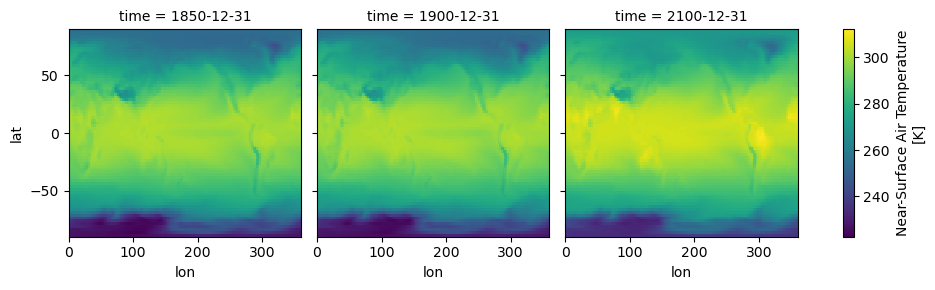

In [67]:
data_ds.isel(time=[0, 50, -1], member=20).plot(col='time')

In [68]:
data_ds

<xarray.DataArray 'tas' (member: 40, time: 251, lat: 72, lon: 144)> Size: 833MB
dask.array<open_dataset-tas, shape=(40, 251, 72, 144), dtype=float64, chunksize=(1, 251, 6, 12), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (7)

<h2 style='color: cyan'> ERA5 Resample (large data) </h2>

In [69]:
# MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
# output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
# output_file

In [70]:
# data_ds = xr.open_zarr(str(output_file), chunks=CHUNKS_FOR_ERA5)[variable]#.to_array()
# data_ds = data_ds.fillna(0)

In [71]:
# data_ds

In [72]:
# data_ds = data_ds.isel(time=slice(None, -1))

<h2 style='color:cyan'> Data Check </h2>

In [73]:
data_ds = data_ds.transpose(..., "time").chunk(chunks).persist()
wait(data_ds);

In [74]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 221)> Size: 733MB
dask.array<getitem, shape=(40, 72, 144, 221), dtype=float64, chunksize=(1, 6, 12, 221), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Attributes: (7)

In [75]:
chunks

{'time': -1, 'member': 1, 'lat': 6, 'lon': 12}

In [76]:
# Make sure chunks is 1
assert len(data_ds.chunksizes['time']) == 1

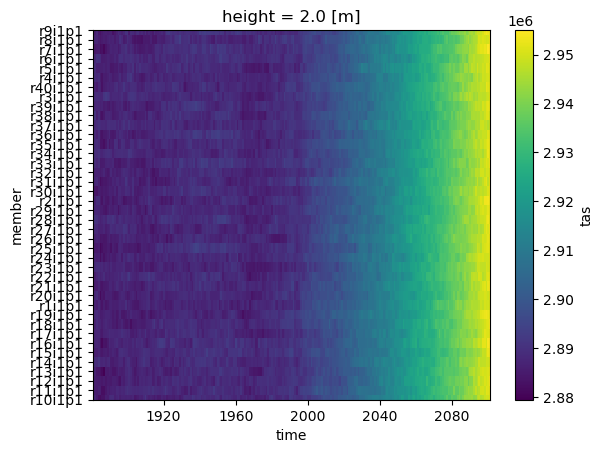

In [77]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

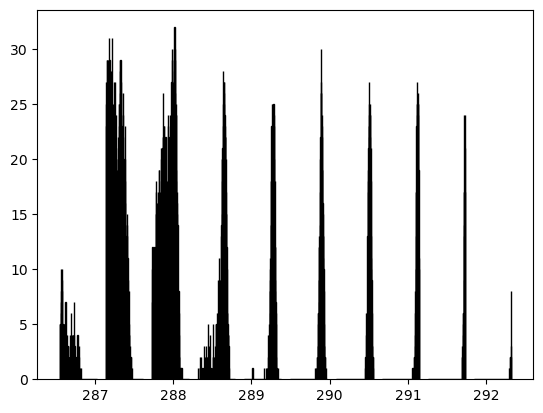

In [78]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

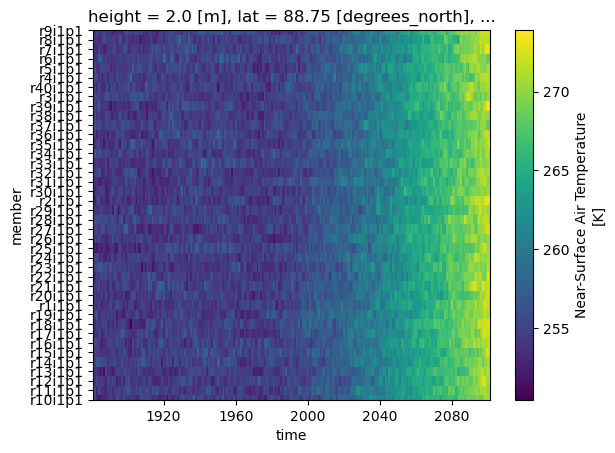

In [79]:
data_ds.sel(lat=89.5, lon=-29.75, method='nearest').plot()

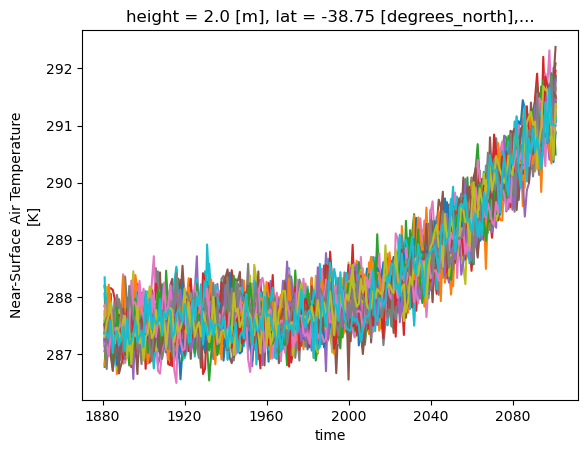

In [80]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

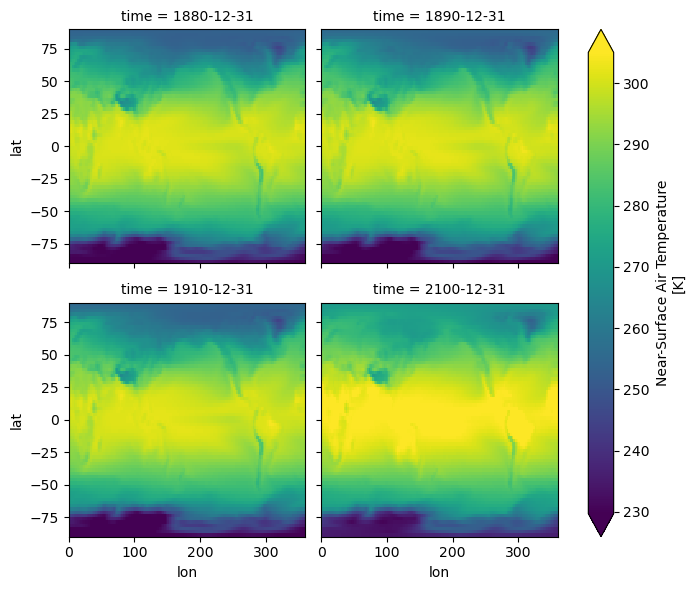

In [81]:
data_ds.isel(time=[0, 10, 30, -1], **ensemble_kwargs).plot(col='time', col_wrap=2, robust=True)

In [82]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")

Statistics:
Min: 221.04
25th Percentile: 267.38
75th Percentile: 296.96
Max: 314.41


In [83]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(221,
 array(['1880-12-31T00:00:00.000000000', '1881-12-31T00:00:00.000000000',
        '1882-12-31T00:00:00.000000000', '2098-12-31T00:00:00.000000000',
        '2099-12-31T00:00:00.000000000', '2100-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [84]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(221,
 array(['1880-12-31T00:00:00.000000000', '1881-12-31T00:00:00.000000000',
        '1882-12-31T00:00:00.000000000', '2098-12-31T00:00:00.000000000',
        '2099-12-31T00:00:00.000000000', '2100-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

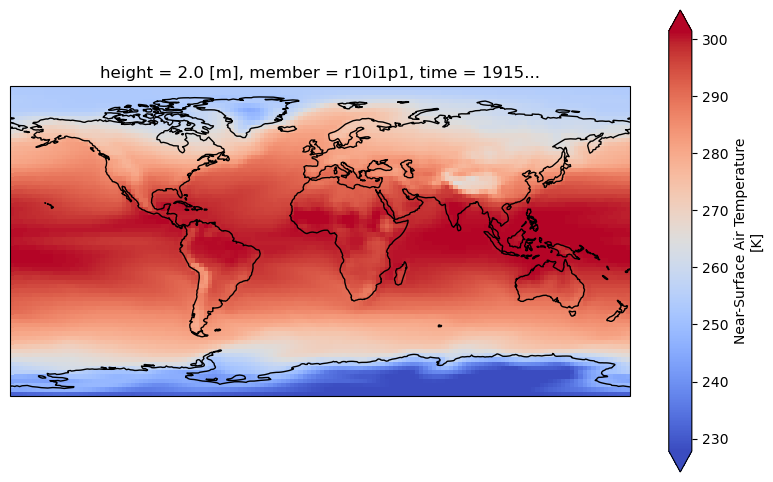

In [85]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35, **ensemble_kwargs).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [86]:
base_period_ds = data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
base_period_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 30)> Size: 100MB
dask.array<getitem, shape=(40, 72, 144, 30), dtype=float64, chunksize=(1, 6, 12, 30), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 240B 1880-12-31 1881-12-31 ... 1909-12-31
Attributes: (7)

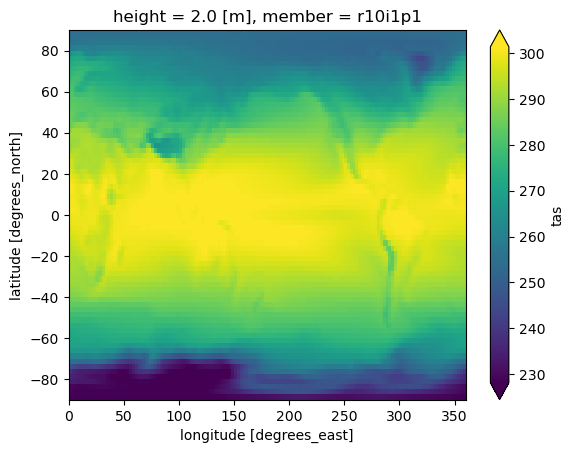

In [87]:
base_period_ds.mean(dim='time').isel(**ensemble_kwargs).plot(robust=True)

In [88]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144)> Size: 3MB
dask.array<where, shape=(40, 72, 144), dtype=int64, chunksize=(1, 6, 12), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'

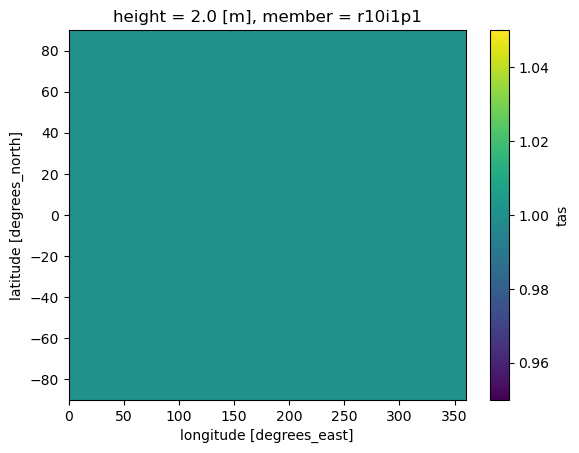

In [89]:
data_availability_mask.isel(**ensemble_kwargs).plot()

In [90]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [91]:
# Resetting the anomlies to 1850
data_anom_ds = data_ds - base_period_ds.mean(dim='time')
base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')

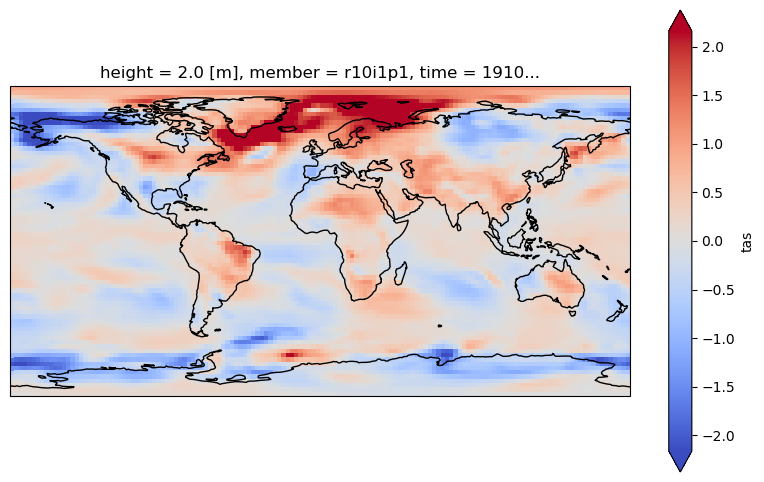

In [92]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_anom_ds.isel(time=30, **ensemble_kwargs).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

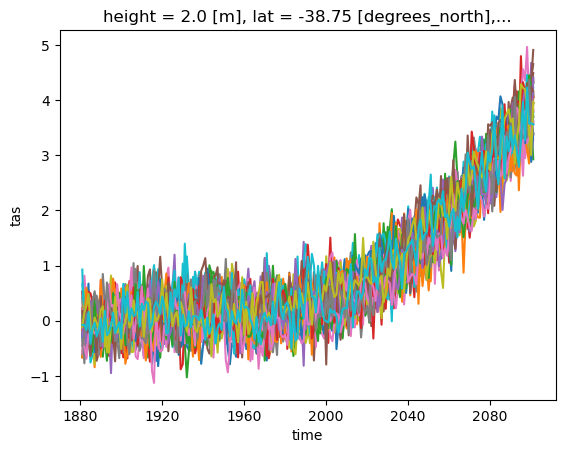

In [93]:
data_anom_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

In [94]:
data_ds.sel(lat=-38, lon=145, method='nearest').values

array([[287.34, ..., 291.48],
       ...,
       [287.36, ..., 291.  ]])

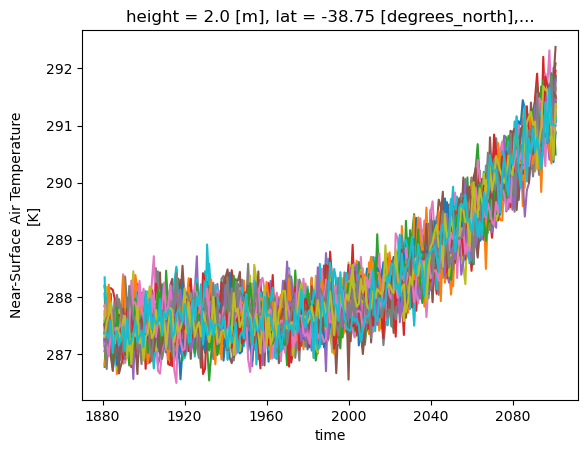

In [95]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [96]:
window = 30

In [97]:
CHUNKS_FOR_PVALUE_TESTS = chunks

In [98]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [99]:
wait(data_ds_window);
wait(base_period_window_ds);

In [100]:
data_ds_window

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 221,
                         window_dim: 30)> Size: 22GB
dask.array<rechunk-merge, shape=(40, 72, 144, 221, 30), dtype=float64, chunksize=(1, 6, 12, 221, 30), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Dimensions without coordinates: window_dim
Attributes: (7)

In [101]:
data_ds_window.chunks

((1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1),
 (6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6),
 (12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12),
 (221,),
 (30,))

In [102]:
base_period_window_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, window_dim: 30)> Size: 100MB
dask.array<getitem, shape=(40, 72, 144, 30), dtype=float64, chunksize=(1, 6, 12, 30), chunktype=numpy.ndarray>
Coordinates:
    height      float64 8B 2.0
  * lat         (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon         (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member      (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * window_dim  (window_dim) datetime64[ns] 240B 1880-12-31 ... 1909-12-31
Attributes: (7)

In [103]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [104]:
# # P-value methods works better with a large cluster.
# # Small chunks with large computation
client.cluster.scale(100);
sleep(7);

 -         Start Nanny at: 'tcp://127.0.0.1:45835'
 -         Start Nanny at: 'tcp://127.0.0.1:35399'
 -         Start Nanny at: 'tcp://127.0.0.1:40293'
 -         Start Nanny at: 'tcp://127.0.0.1:45571'
 -         Start Nanny at: 'tcp://127.0.0.1:36155'
 -         Start Nanny at: 'tcp://127.0.0.1:41203'
 -         Start Nanny at: 'tcp://127.0.0.1:41805'
 -         Start Nanny at: 'tcp://127.0.0.1:39487'
 -         Start Nanny at: 'tcp://127.0.0.1:45575'
 -         Start Nanny at: 'tcp://127.0.0.1:39915'
 -         Start Nanny at: 'tcp://127.0.0.1:41547'
 -         Start Nanny at: 'tcp://127.0.0.1:38825'
 -         Start Nanny at: 'tcp://127.0.0.1:34163'
 -         Start Nanny at: 'tcp://127.0.0.1:41479'
 -         Start Nanny at: 'tcp://127.0.0.1:38249'
 -         Start Nanny at: 'tcp://127.0.0.1:43373'
 -         Start Nanny at: 'tcp://127.0.0.1:42925'
 -         Start Nanny at: 'tcp://127.0.0.1:46427'
 -         Start Nanny at: 'tcp://127.0.0.1:33493'
 -         Start Nanny at: 'tcp

<h2 style='color: cyan'> Overlap Methods - Optimized</h2>

In [105]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

### Perkins

In [106]:
data_arr = data_ds.values.flatten()
data_arr.shape
# #data_arr = data_arr[data_arr != 0]

(91653120,)

In [107]:
bins = toe_calc.calculate_freedman_diaconis_bins(
    data_arr, length=len(data_ds.time.values), logginglevel='DEBUG')

np.unique(np.diff(bins).round(6)).item(), bins

p75=296.95639111254405, p25=267.377682701774, iqr=29.578708410770048, length=221
 - 9.784645834366739


(9.784646,
 array([211.26, 221.04, 230.83, 240.61, 250.4 , 260.18, 269.97, 279.75,
        289.53, 299.32, 309.1 , 318.89]))

In [108]:
bins = np.arange(bins[0], bins[-1]+0.5, 0.5)

In [109]:
bins

array([211.26, 211.76, 212.26, 212.76, 213.26, 213.76, 214.26, 214.76,
       215.26, 215.76, 216.26, 216.76, 217.26, 217.76, 218.26, 218.76,
       219.26, 219.76, 220.26, 220.76, 221.26, 221.76, 222.26, 222.76,
       223.26, 223.76, 224.26, 224.76, 225.26, 225.76, 226.26, 226.76,
       227.26, 227.76, 228.26, 228.76, 229.26, 229.76, 230.26, 230.76,
       231.26, 231.76, 232.26, 232.76, 233.26, 233.76, 234.26, 234.76,
       235.26, 235.76, 236.26, 236.76, 237.26, 237.76, 238.26, 238.76,
       239.26, 239.76, 240.26, 240.76, 241.26, 241.76, 242.26, 242.76,
       243.26, 243.76, 244.26, 244.76, 245.26, 245.76, 246.26, 246.76,
       247.26, 247.76, 248.26, 248.76, 249.26, 249.76, 250.26, 250.76,
       251.26, 251.76, 252.26, 252.76, 253.26, 253.76, 254.26, 254.76,
       255.26, 255.76, 256.26, 256.76, 257.26, 257.76, 258.26, 258.76,
       259.26, 259.76, 260.26, 260.76, 261.26, 261.76, 262.26, 262.76,
       263.26, 263.76, 264.26, 264.76, 265.26, 265.76, 266.26, 266.76,
      

In [110]:
# dmin = data_ds.min().values.item()
# dmax = data_ds.max().values.item()
# dmin, dmax

In [111]:
# bins = np.arange(dmin, dmax+1, 1)

In [112]:
# np.min(bins), np.max(bins)

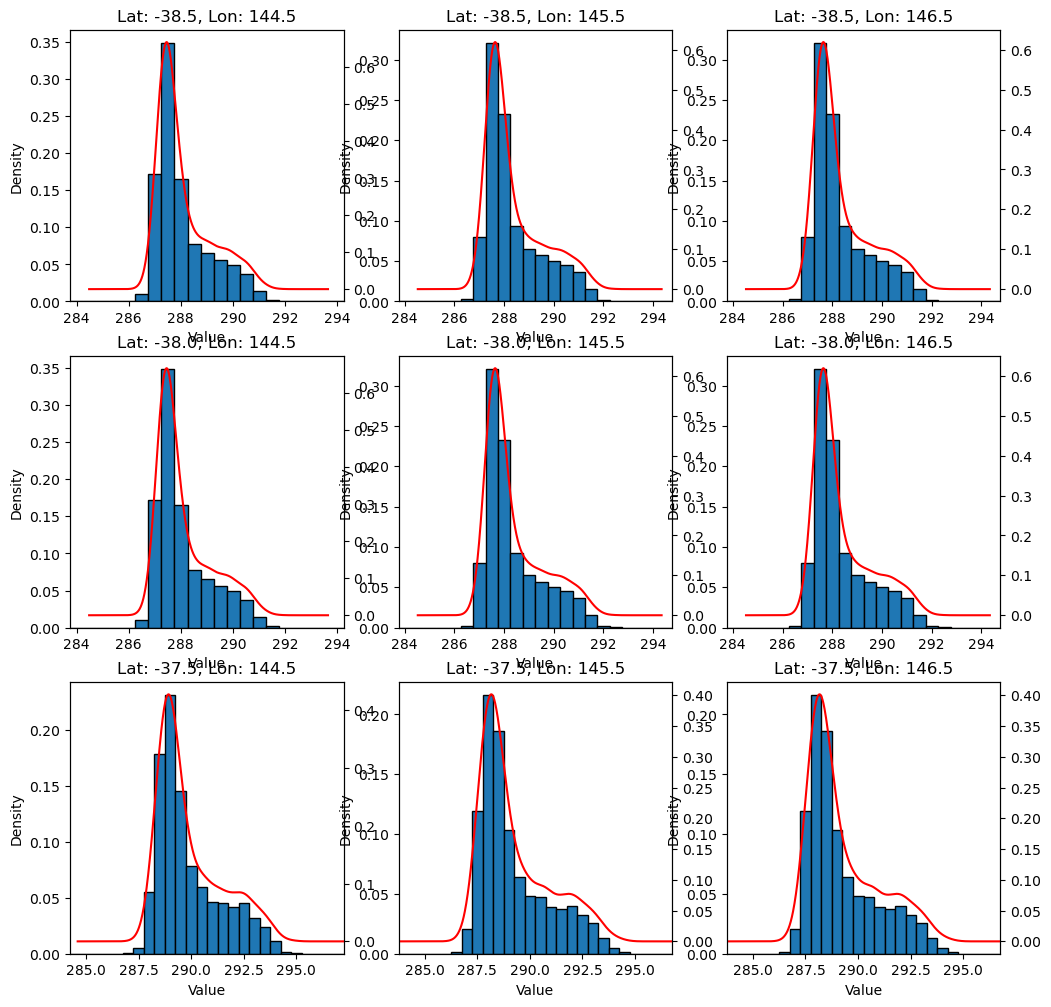

In [113]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [114]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

CPU times: user 40.4 s, sys: 9.64 s, total: 50.1 s
Wall time: 44.4 s


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 29, 0, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 22, 11, 10, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 28, 10, 7, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 18, 0, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 9, 9, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 5, 11, 9, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 12, 9, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 30, 3, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5efc3eda665aa1d1799630fbc46bc50e', 6, 1, 4, 0)>, <Future:

In [115]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

CPU times: user 39.5 s, sys: 18.6 s, total: 58.1 s
Wall time: 1min 15s


In [116]:
perkins_ds = perkins_ds.sortby('lat')

In [117]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [118]:
location = dict(lat=69, lon=-165, method='nearest')

 - locator: <matplotlib.ticker.AutoLocator object at 0x1478e1cb6620>


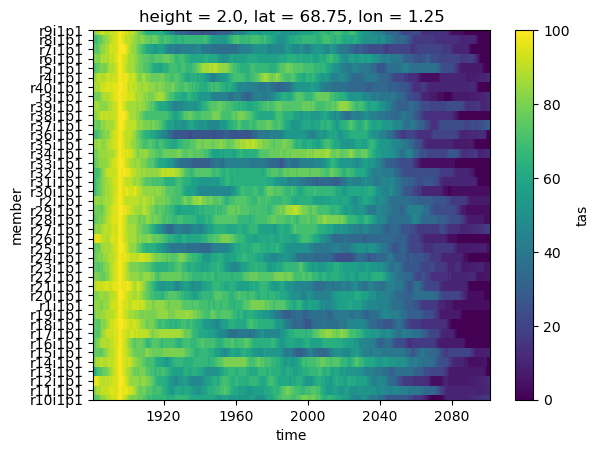

In [119]:
perkins_ds.sel(**location).plot()

In [120]:
base_arr = base_period_ds.isel(ensemble_kwargs).sel(**location).values


future_arr = (data_ds.sel(**location)
              .isel(ensemble_kwargs)
              .sel(time=slice(str(base_period.start), str(base_period.end)))
              .values)

rel_freq_base = toe_calc.rel_freq(base_arr, bins)
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [121]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=int(window/2), **ensemble_kwargs).values.item()

(100.0, 100.0, 100.0)

<Axes: >

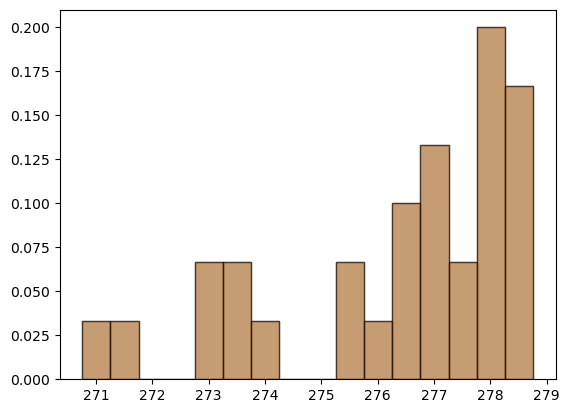

In [122]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [123]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.isel(ensemble_kwargs).sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 31)).values,
    base_period_rel_freq_ds.isel(ensemble_kwargs).sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

96.54320987654322

<BarContainer object of 216 artists>

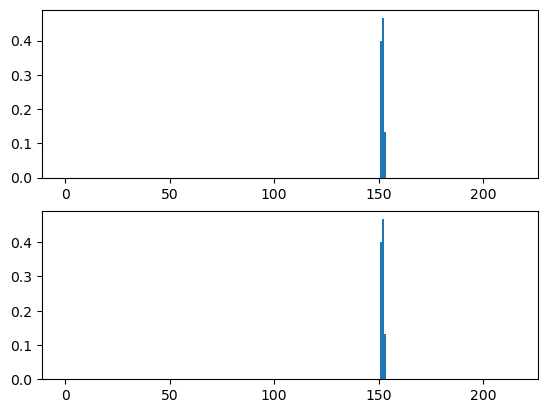

In [124]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).isel(**ensemble_kwargs).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).isel(**ensemble_kwargs).values)

 - colorbar update normal <matplotlib.colors.Normalize object at 0x147caba9d600> <matplotlib.colors.Normalize object at 0x147caba9d600>
 - locator: <matplotlib.ticker.AutoLocator object at 0x1478e637ce80>
 - colorbar update normal <matplotlib.colors.Normalize object at 0x147caba9d600> <matplotlib.colors.Normalize object at 0x147caba9d600>
 - locator: <matplotlib.ticker.AutoLocator object at 0x1478e637ce80>
 - locator: <matplotlib.ticker.AutoLocator object at 0x147cfc07c1f0>


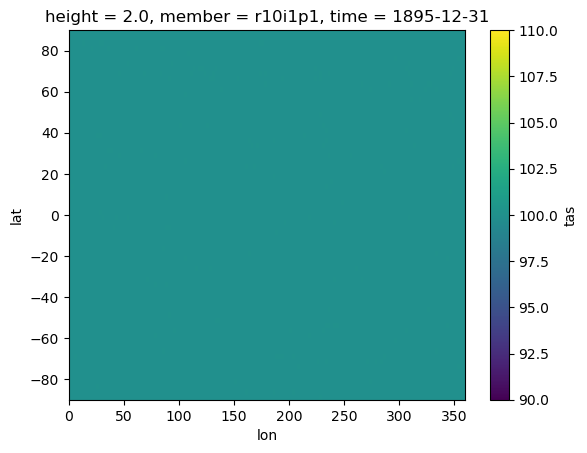

In [125]:
perkins_ds.isel(time=int(window/2), **ensemble_kwargs).plot();

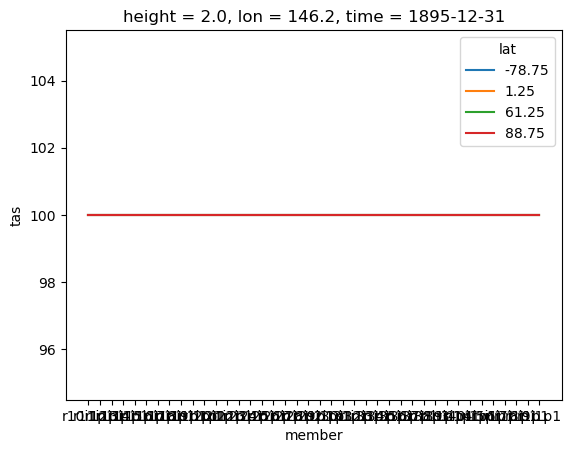

In [126]:
# These should all be 100
perkins_ds.sel(lat=[-80, 0, 60, 88], lon=145, method='nearest').isel(time=window//2).plot(hue='lat');

 - locator: <matplotlib.ticker.FixedLocator object at 0x147ca9f7ee00>


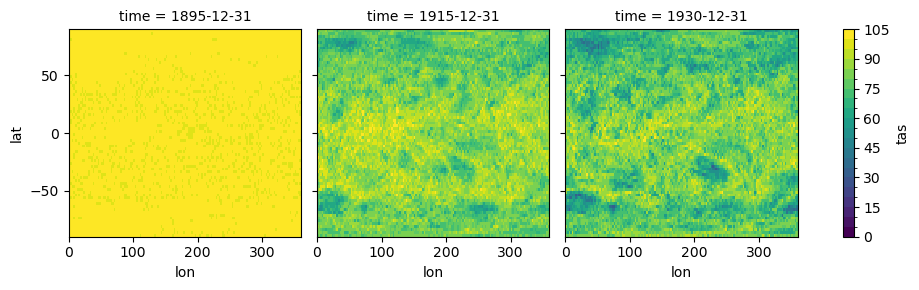

In [127]:
perkins_ds.isel(time=[int(window/2), 35, 50], **ensemble_kwargs).plot(col='time', levels=np.arange(0, 110, 5))

### KDE Metrics

In [128]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(221.04195517900644, 314.4096705544513, (1000,))

In [129]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 38.5 s, sys: 10 s, total: 48.5 s
Wall time: 42.9 s


In [130]:
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
latlon_dict = dict(lat=0.5, lon=-29.75, method='nearest')
toe_calc.hellinger_distance_optimized(
    arr_future=data_ds_window.sel(**latlon_dict).isel(time=slice(30, 60)).values,
    kde_base = base_period_kde.sel(**latlon_dict).values,
    x=x
)

133.4401577025515

In [131]:
%%time
hellinger_ds = xr.apply_ufunc(
    toe_calc.hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()

CPU times: user 2min 14s, sys: 1min 43s, total: 3min 57s
Wall time: 13min 26s


In [ ]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe_calc.fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

In [ ]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [ ]:
hellinger_ds

In [ ]:
hellinger_ds.attrs

In [ ]:
hellinger_ds.isel(time=[10, 35, 50], **ensemble_kwargs).plot(col='time', levels=np.arange(0, 110, 10))

In [ ]:
frac_geom_ds.isel(time=[10, 35, 50], **ensemble_kwargs).plot(col='time', levels=np.arange(0, 110, 10))

In [ ]:
frac_geom_ds.isel(time=window//2, **ensemble_kwargs).plot();

In [ ]:
hellinger_ds.isel(time=window//2, **ensemble_kwargs).plot();

In [ ]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = toe_calc.create_kde_x_exists(
    base_period_ds.sel(**test_loc).isel(**ensemble_kwargs).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).isel(**ensemble_kwargs).values)
ax1.plot(x, test_kde, linestyle='--')

### Old - Ufunc

In [ ]:
# %%time
# perkins_ds = xr.apply_ufunc(
#     toe_calc.perkins_skill_score,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs={'bins': bins},
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute().sortby('lat')

In [ ]:
# %%time
# frac_geom_ds = xr.apply_ufunc(
#     toe_calc.fractional_geometric_area,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

In [ ]:
# %%time
# hellinger_ds = xr.apply_ufunc(
#     toe_calc.hellinger_distance,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [ ]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [ ]:
%%time
# Expected: 9 minutes 30 seconds
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [188]:
ttest_ds

<xarray.DataArray 'ttest' (member: 40, lat: 72, lon: 144, time: 221)> Size: 733MB
array([[[[0.33, ..., 0.  ],
         ...,
         [0.32, ..., 0.  ]],

        ...,

        [[0.57, ..., 0.  ],
         ...,
         [0.56, ..., 0.  ]]],


       ...,


       [[[0.74, ..., 0.  ],
         ...,
         [0.74, ..., 0.  ]],

        ...,

        [[0.23, ..., 0.  ],
         ...,
         [0.23, ..., 0.  ]]]])
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Attributes: (1)

In [ ]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_availability_mask)

In [ ]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [172]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [174]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length=base_period.length+1)

In [176]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).isel(**ensemble_kwargs).values)

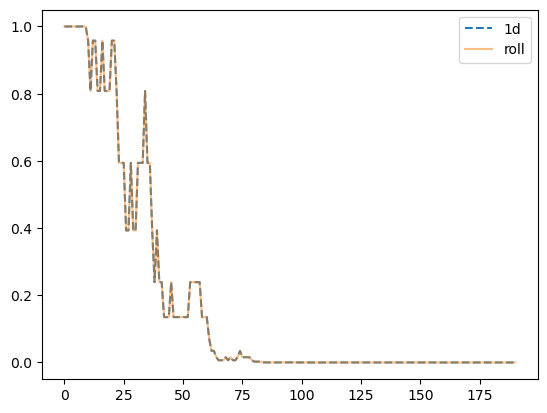

In [178]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2)), **ensemble_kwargs).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

<b> Hawkins S/N Ratio</b>

In [ ]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_anom_ds).compute()

 - locator: <matplotlib.ticker.AutoLocator object at 0x1476be7d3010>


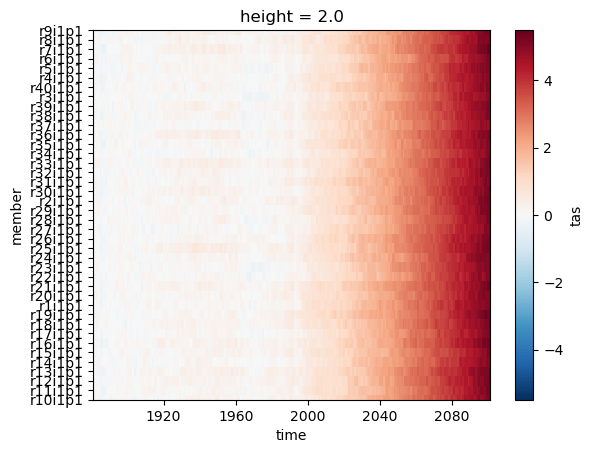

In [168]:
data_ds_smean.plot()

In [ ]:
# Get lowess filtered version
# ds_smean_lowess = my_stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [ ]:
# %%time
# return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
#                                                   gt=ds_smean_lowess.values)

# ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
#     return_hawkins_signal_and_noise_partial,
#     data_anom_ds,
#     input_core_dims=[['time']], 
#     output_core_dims=[['time'], ['time']], 
#     dask='parallelized', 
#     vectorize=True,
#     output_dtypes=[float, float],
# )

# ds_signal_hawkins = ds_signal_hawkins.compute()
# ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

In [ ]:
# # Noise 
# ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

# ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
#     ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# # S/N Ratio 
# ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
# ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

<b> Lowess S/N </b>

In [ ]:
ds_signal_lowess = xr.apply_ufunc(
    my_stats.apply_lowess, 
    data_anom_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    kwargs = dict(window=41),
    dask='parallelized',
    output_dtypes=[float]
).compute()

In [ ]:
# Noise series is detrended data
ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

ds_noise_lowess_base_period = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio
ds_sn_lowess_full = ds_signal_lowess/ds_noise_lowess_full
ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period

In [ ]:
ds_signal_mean = data_anom_ds.rolling(time=window, center=True).mean().persist()

# data_detrend_mean = (data_anom_ds - ds_signal_mean).persist()
# Detrended usign lowess or else 2 x 15 year periods on either end is lost
ds_std_roll = ds_noise_series_lowess.rolling(time=window, center=True).std().persist()

ds_sn_mean = ds_signal_mean/ds_noise_series_lowess.std(dim='time').persist()
wait(ds_sn_mean);

In [ ]:
# base_period_std = data_detrend_mean.sel(time=slice(str(base_period.start), str(base_period.end))).std(dim='time').persist()

In [ ]:
ds_rolling_noise = (np.sqrt(1/2*(ds_noise_lowess_base_period**2+ds_std_roll**2))).persist()
wait(ds_rolling_noise)

In [189]:
ds_sn_mean_roll = (ds_signal_mean/ds_rolling_noise).persist()
wait(ds_sn_mean_roll);

### Plot Verificaiton

In [190]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

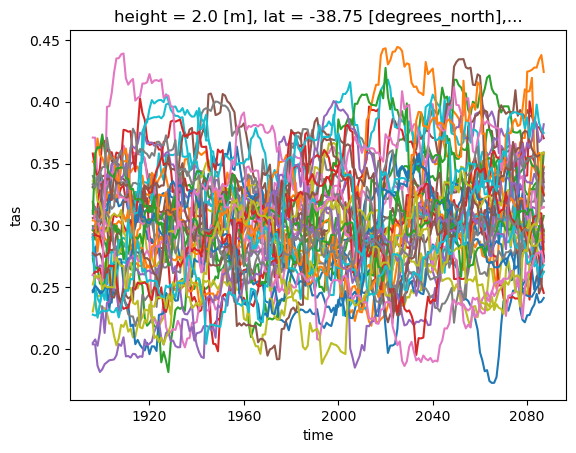

In [191]:
ds_std_roll.sel(**lat_lon_sp).plot(**plot_kwargs);

Text(0.5, 1.0, 'S/N')

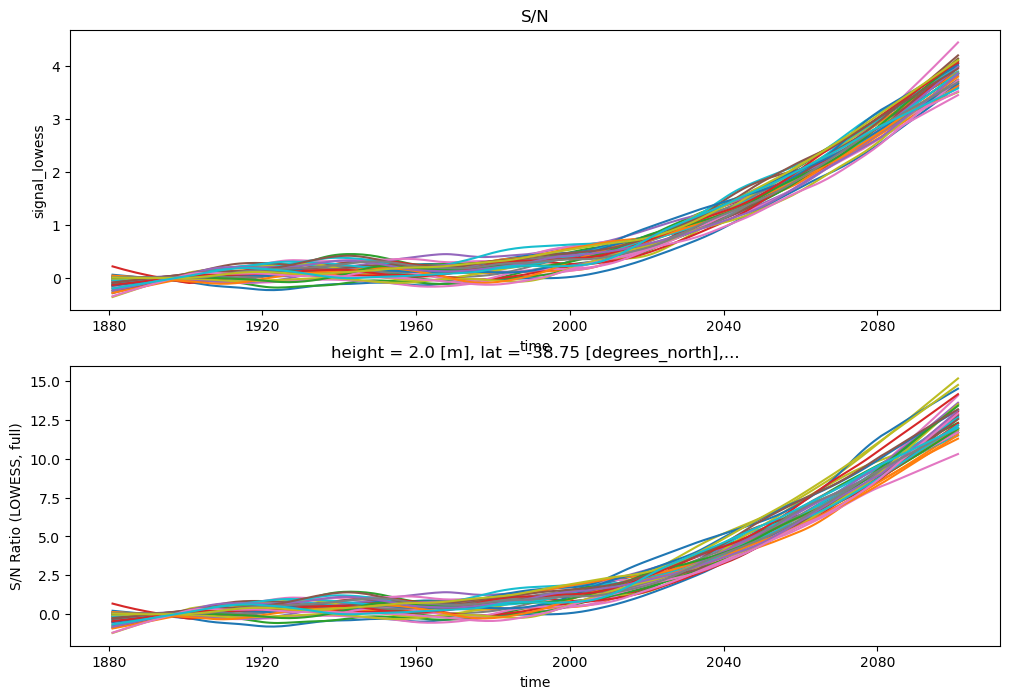

In [192]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ds_signal_lowess.sel(**lat_lon_sp).plot(ax=axes[0], **plot_kwargs);

ds_sn_lowess_full.sel(**lat_lon_sp).plot(ax=axes[1], **plot_kwargs);


axes[0].set_title('Signal')
axes[0].set_title('S/N')

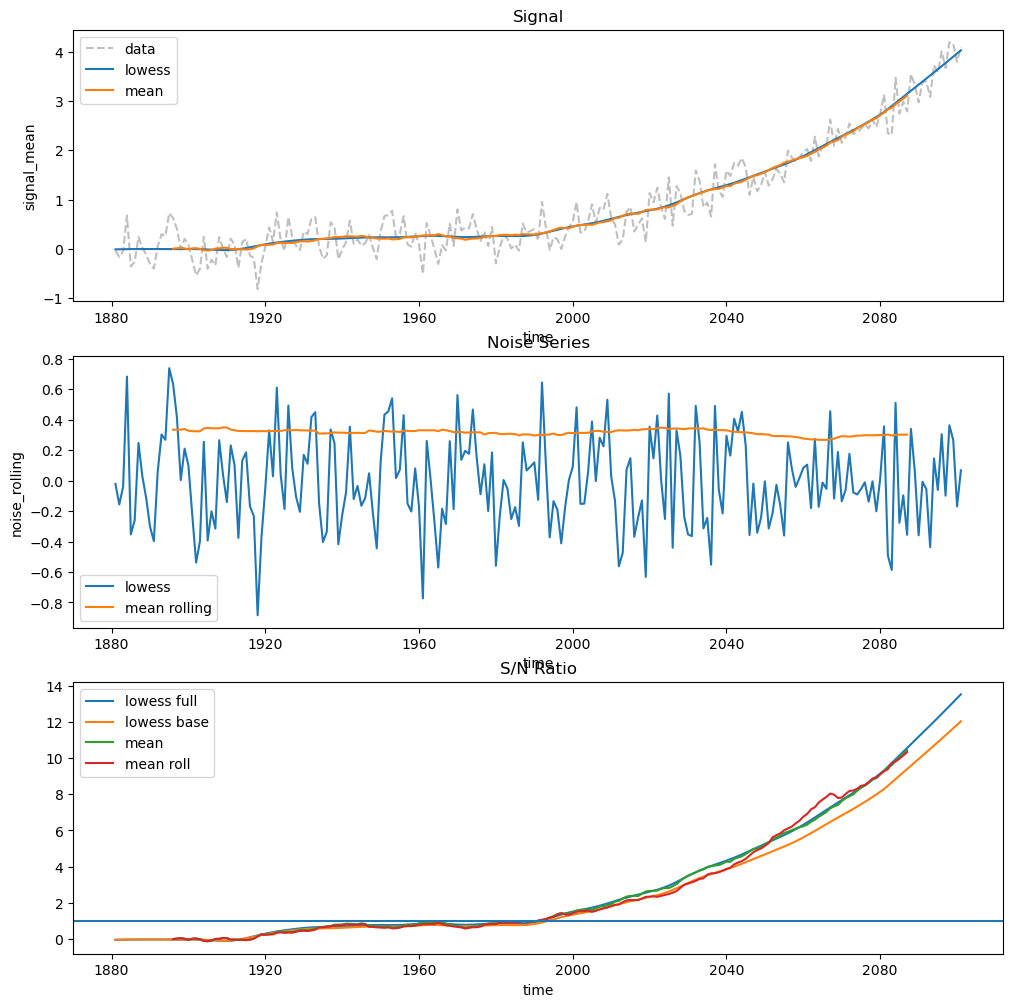

In [193]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_anom_ds.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_mean.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='mean', ax=ax1)
# ds_signal_hawkins.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)

ax1.set_title('Signal')
ax1.legend()

#####
ax2= axes[1]
ds_noise_series_lowess.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
# ds_noise_series_hawkins.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
ds_rolling_noise.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='mean rolling', ax=ax2)
ax2.set_title('Noise Series')

ax2.legend()


####
ax3= axes[2]
ds_sn_lowess_full.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
ds_sn_lowess_base_period.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)
ds_sn_mean.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='mean', ax=ax3)
ds_sn_mean_roll.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='mean roll', ax=ax3)


# ds_sn_hawkins_full.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
# ds_sn_hawkins_base_period.isel(**ensemble_kwargs).sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax3.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

 - locator: <matplotlib.ticker.AutoLocator object at 0x1475caa970d0>


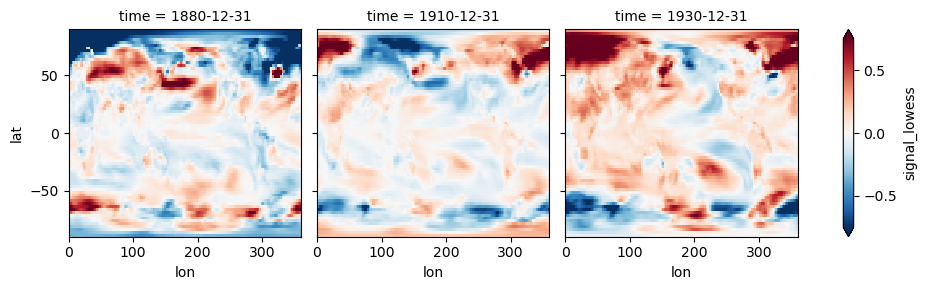

In [194]:
ds_signal_lowess.isel(time=[0, 30, 50], **ensemble_kwargs).plot(col='time', robust=True)

In [195]:
# Rolling noise variant
# ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [196]:
# ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

In [197]:
# ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# # First time step is nan for noise, so remove
# ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

In [198]:
# ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [199]:
# ds_data_sn_lowess

In [200]:
# client.cluster.scale(6)
# sleep(7)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [201]:
# ds_signal_mean
# ds_sn_mean
# ds_rolling_noise
# ds_sn_mean_roll

In [202]:
ds_signal_lowess.name = 'signal_lowess'
ds_noise_series_lowess.name = 'noise_lowess'
# ds_signal_hawkins.name = 'signal_hawkins'
# ds_noise_series_hawkins.name = 'noise_hawkins'

ds_signal_mean.name = 'signal_mean'
ds_rolling_noise.name = 'noise_rolling'

In [203]:
# ds_sn_hawkins_full.name = 'sn_hawkins_full'
# ds_sn_hawkins_base_period.name = 'sn_hawkins_base'
ds_sn_lowess_full.name = 'sn_lowess_full'
ds_sn_lowess_base_period.name = 'sn_lowess_base'
ds_sn_mean.name = 'sn_mean'
ds_sn_mean_roll.name = 'sn_mean_roll'

ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [204]:
# Set long name attributes for each variable
# ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
# ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

ds_sn_lowess_full.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
ds_sn_lowess_base_period.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'

ds_sn_mean.attrs['long_name'] = 'S/N Ratio (Mean, base)'
ds_sn_mean_roll.attrs['long_name'] = 'S/N Ratio (Mean, base+rolling)'


ttest_ds.attrs['long_name'] = 'T-Test'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [205]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, perkins_ds, frac_geom_ds, hellinger_ds,
                           # ds_sn_hawkins_full,ds_sn_hawkins_base_period,
                          ds_sn_lowess_full, ds_sn_lowess_base_period,
                          ds_sn_mean, ds_sn_mean_roll])

toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 6GB
Dimensions:         (lat: 72, lon: 144, member: 40, time: 191)
Coordinates:
    height          float64 8B 2.0
  * lat             (lat) float64 576B -88.75 -86.25 -83.75 ... 86.25 88.75
  * lon             (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member          (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time            (time) datetime64[ns] 2kB 1895-12-31 ... 2085-12-31
Data variables:
    ks              (member, lat, lon, time) float64 634MB 1.0 1.0 ... 1.691e-17
    ttest           (member, lat, lon, time) float64 634MB 1.0 ... 8.958e-41
    perkins         (member, lat, lon, time) float64 634MB 100.0 96.67 ... 0.0
    frac            (member, lat, lon, time) float64 634MB 100.0 ... 9.221e-48
    hd              (member, lat, lon, time) float64 634MB 0.0 4.727 ... 100.0
    sn_lowess_full  (member, lat, lon, time) float64 634MB -0.1037 ... 14.99
    sn_lowess_base  (member, lat, lon, time) float64 634MB -0.1201 ... 15.7
    sn_mean         (member, lat, lon, time) float64 634MB 4.358e-15 ... 14.79
    sn_mean_roll    (member, lat, lon, time) float64 634MB 4.902e-15 ... 16.68
Attributes: (1)

In [208]:
dataset_name, variable, base_period

('access_ssp585', 'tas', BasePeriod(start=1880, end=1909))

In [212]:
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)'

In [213]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_anom_ds.to_zarr(DATA_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)/data.zarr


In [214]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([
    ds_signal_lowess,ds_noise_series_lowess,
    # ds_signal_hawkins , ds_noise_series_hawkins,
    ds_signal_mean, ds_rolling_noise]) 
singal_ds

<xarray.Dataset> Size: 3GB
Dimensions:        (lat: 72, lon: 144, member: 40, time: 221)
Coordinates:
    height         float64 8B 2.0
  * lat            (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon            (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member         (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time           (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
Data variables:
    signal_lowess  (member, lat, lon, time) float64 733MB -0.3587 ... 17.92
    noise_lowess   (member, lat, lon, time) float64 733MB 1.874 ... 0.05683
    signal_mean    (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 6, 12, 220), meta=np.ndarray>
    noise_rolling  (member, lat, lon, time) float64 733MB nan nan ... nan nan

In [215]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
print(SIGNAL_SAVE_NAME)
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)/signal.zarr


In [216]:
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)/toe_metrics.zarr


In [221]:
data_availability_mask = data_availability_mask.chunk('auto')

In [222]:
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'data_availability_mask.zarr')
print(DATA_AVAILABILITY_SAVE_NAME)
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_(1880_1909)/data_availability_mask.zarr


In [219]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')

time_taken=142.72135816812516minutes
